## 0)import libraries 

In [109]:
import os
import pickle

import dask.array as da
import numpy as np
import pandas as pd
import xarray as xr

from PyStemmusScope import variable_conversion as vc
from sklearn.preprocessing import OneHotEncoder
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

In [2]:
cluster = LocalCluster(n_workers=5, threads_per_worker=1)
client = Client(cluster)
client

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36611 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36611/status,
Dashboard: /proxy/36611/status,Workers: 5
Total threads: 5,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40007,Workers: 5
Dashboard: /proxy/36611/status,Total threads: 5
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:42857,Total threads: 1
Dashboard: /proxy/42279/status,Memory: 24.00 GiB
Nanny: tcp://127.0.0.1:34893,


## 1)settings for Dask

Setup a Dask cluster on 6 * 16 = 96 cores (6 * 4 = 24 workers with 4 threads each) and 6 * 120 GB = 720 GB memory in total ('fat' nodes on Snellius):

In [110]:
cluster = SLURMCluster(
    name='dask-worker',
    cores=16,
    processes=4,
    queue='fat',
    memory='120GiB',
    local_directory='$TMPDIR',
    walltime='1:00:00'
)
cluster.scale(jobs=8)

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38239 instead
  warnings.warn(


In [111]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/38239/status,
Dashboard: /proxy/38239/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://145.136.63.38:35789,Workers: 0
Dashboard: /proxy/38239/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [112]:
print(client.cluster)  # 输出 worker 数量、总核心数、总内存

dask-worker(dask-worker, 'tcp://145.136.63.38:35789', workers=0, threads=0, memory=0 B)


## 2)define working path, load trained model, define functions

In [113]:
year = 2014

In [144]:
ROOT_DIR = '/gpfs/work2/0/ttse0619'
DATA_DIR = f'{ROOT_DIR}/qianqian/global_data_Qianqian/1input_data'
ERA5_PATH = f'{DATA_DIR}/{year}global/era5land/era5land_{year}.zarr'
LAI_PATH = f'{DATA_DIR}/{year}global/lai_v2/lai_v2_{year}.zarr'
SSM_PATH = f'{DATA_DIR}/{year}global/ssm/ssm_global_{year}.zarr'
CO2_PATH = f'{DATA_DIR}/{year}global/co2/co2_{year}.zarr'
LANDCOVER_PATH = f'{DATA_DIR}/landcover/landcover.zarr'
IGBP_CLASS_PATH = f'{DATA_DIR}/landcover/IGBP11unique.csv'
IGBP_TABLE_PATH = f'{DATA_DIR}/landcover//lccs_to_igbp_table.csv' 
hc_PATH = f'{DATA_DIR}/canopy_height/hc_global.zarr'
VCMAX_PATH = f'{DATA_DIR}/Vcmax/vcmax_fillnan.zarr'
MODEL_PATH = f'{ROOT_DIR}/qianqian/global_data_Qianqian/3RF_train/hourlyFluxes_OI2024-11-05.pkl'

LEH_PATH = f'{ROOT_DIR}/qianqian/global_data_Qianqian/5output_data/global_fluxes_RFOI_{year}_v1.3.zarr'

In [115]:
# function for loading the trained model
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti

## 3) read data

In [245]:
## 0) read era5land data
era5 = xr.open_zarr(ERA5_PATH)
# round coordinates to facilitate matching with other datasets
era5 = era5.assign_coords(
    longitude=era5.longitude.round(4),
    latitude=era5.latitude.round(4)
).sel(time=slice('2014-01-01', '2014-01-31'))

In [246]:
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import mapping
from shapely.affinity import translate

shapefile_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/Emulator/input_data/EuropeBoundary.shp"
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds

In [10]:
# 120 x 120 degrees
era5 = era5.sel(
    latitude=slice(34.93055094,81.85192337),  # (0., 125.) deg
    longitude=slice(0, 68.93136141),  # (90., -35.) deg
)

In [15]:
era5 = era5.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))

In [247]:
# calculate the Rin and Rli difference for every hour
ssrd = era5['ssrd'] / 3600
Rin = ssrd.diff("time")
Rin[0::24] = ssrd[1::24]

strd = era5['strd'] / 3600
Rli = strd.diff("time")
Rli[0::24] = strd[1::24]

In [248]:
Precip_msr = era5['tp'].diff("time")  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Precip_msr[0::24] = era5['tp'][1::24] # assign the original values in t01

In [249]:
p = era5["sp"]/100  # Pa -> hPa
Ta = era5["t2m"] - 273.15  # K -> degC
ea = vc.calculate_es(era5["d2m"] - 273.15)*10 #kPa -> hPa
u = (era5["u10"] ** 2 + era5["v10"] ** 2) ** 0.5
Precip_msr = Precip_msr*1000 # mm

In [255]:
### 1) read LAI data
LAI = xr.open_zarr(LAI_PATH)#.sel(time=str(year))
LAI = LAI.assign_coords(
    longitude=LAI.longitude.round(4),
    latitude=LAI.latitude.round(4)
)['LAI'].sel(time=slice('2013-12-31', '2014-01-31'))

In [256]:
LAI['longitude'] = LAI['longitude'].astype('float32')

In [252]:
print(LAI['latitude'].dtype)  # 确认为 float64
print(LAI['longitude'].dtype)  # 确认为 float64

float32
float32


In [22]:
LAI = LAI.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
# LAI = LAI.sel(
#     latitude=slice(34.93055094, 81.85192337),  # (0., 125.) deg
#     longitude=slice(0, 68.93136141),  # (90., -35.) deg
# )

Interpolation creates a single chunk in time! Can we use nearest-neighbour to match the time domain of the ERA5 dataset instead?

In [253]:
# # # INTERPOLATION CREATES A SINGLE CHUNK IN TIME!
# LAI = LAI.resample(time='1D').interpolate('linear')

The following Dask option allows to avoid creating a single time chunk when using nearest-neighbour matching: 

In [257]:
import dask.config

with dask.config.set({"array.slicing.split_large_chunks": True}):
    LAI = LAI.resample(time='1H').nearest()

In [258]:
LAI = LAI.sel(time=str(year))

In [259]:
LAI

<xarray.DataArray 'LAI' (time: 721, latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(721, 1801, 3600), dtype=float64, chunksize=(248, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-01-31

In [260]:
### 2) read SSM data
SSM = xr.open_zarr(SSM_PATH)
SSM = SSM.assign_coords(
    longitude=SSM.longitude.round(4),
    latitude=SSM.latitude.round(4)
).sel(time=slice('2014-01-01', '2014-01-31'))


In [27]:
SSM = SSM.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
# SSM = SSM.sel(
#     latitude=slice(34.93055094,81.85192337),  # (0., 125.) deg
#     longitude=slice(0, 68.93136141),  # (90., -35.) deg
# )

In [261]:
SSM = SSM['SSM']

In [262]:
# # INTERPOLATION CREATES A SINGLE CHUNK IN TIME!
SSM = SSM.resample(time='1H').interpolate('linear')/1000 

In [263]:
### 3) read CO2 data
CO2 = xr.open_zarr(CO2_PATH)
CO2 = CO2.assign_coords(
    longitude=CO2.longitude.round(4),
    latitude=CO2.latitude.round(4)
).sel(time=slice('2014-01-01', '2014-01-31'))
CO2 = CO2['co2']
# CO2 = CO2.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
# CO2 = CO2.sel(
#     latitude=slice( 34.93055094, 81.85192337),  # (0., 125.) deg
#     longitude=slice(0, 68.93136141),  # (90., -35.) deg
# )

In [31]:
# # # # INTERPOLATION CREATES A SINGLE CHUNK IN TIME!
# CO2 = CO2.resample(time='1H').interpolate('linear')

In [264]:
with dask.config.set({"array.slicing.split_large_chunks": True}):
    CO2 = CO2.resample(time='1H').nearest()

**Done datasets up to here!** Moving on with landcover

----

In [195]:
## 4) read IGBP data
hc = xr.open_zarr(hc_PATH)
hc = hc.assign_coords(
    longitude=hc.longitude.round(4),
    latitude=hc.latitude.round(4)
)['hc']

In [194]:
hc = hc.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
# hc = hc.sel(
#     latitude=slice(34.93055094,81.85192337),  # (0., 125.) deg
#     longitude=slice(0, 68.93136141),  # (90., -35.) deg
# )

In [196]:
## 5) read Vcmax data
vcmax = xr.open_zarr(VCMAX_PATH)
vcmax = vcmax.assign_coords(
    longitude=vcmax.longitude.round(4),
    latitude=vcmax.latitude.round(4)
)['vcmax']

In [37]:
vcmax = vcmax.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
# vcmax = vcmax.sel(
#     latitude=slice(34.93055094,81.85192337),  # (0., 125.) deg
#     longitude=slice(0, 68.93136141),  # (90., -35.) deg
# )

---

In [197]:
## 6) read IGBP data
landcover = xr.open_zarr(LANDCOVER_PATH)
landcover = landcover.assign_coords(
    longitude=landcover.longitude.round(4),
    latitude=landcover.latitude.round(4)
)['lccs_class']

In [39]:
landcover = landcover.sel(longitude=slice(bbox[0], bbox[2]), latitude=slice(bbox[1], bbox[3]))
# landcover = landcover.sel(
#     latitude=slice(34.93055094, 81.85192337),  # (0., 125.) deg
#     longitude=slice(0, 68.93136141),  # (90., -35.) deg
# )

In [198]:
# read IGBP unique values
training_testing_append = pd.read_csv(IGBP_CLASS_PATH)['0'].unique()
# read the table for converting landcover to IGBP
IGBP_table = pd.read_csv(IGBP_TABLE_PATH)

In [199]:
def landcover_to_igbp(landcover, IGBP_table, training_testing_append):
    get_IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)
    IGBP = get_IGBP(landcover.values) 
    IGBP_all = pd.DataFrame(
        columns=[f'IGBP_veg_long{i}' for i in range(1, 12)]
    )
    
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(
        categories=[training_testing_append],
        sparse=False,
        handle_unknown="ignore"
    )
    
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1], 1))
    
    # assign 23-D IGBP into 23 columns
    for i in range(1, 12):
        IGBP_all[f'IGBP_veg_long{i}'] = aa[:,i-1]
    return IGBP_all

## 4) chunk all the input variables

**Missing data here!** I haven't loaded the CO2 and SSM datasets.

In [265]:
ds = xr.Dataset()

ds = ds.assign(
    Rin=Rin,
    Rli=Rli,
    p=p,
    Ta=Ta,
    ea=ea,
    u=u,
    Precip=Precip_msr,
    LAI=LAI,
    CO2=CO2,
    SSM=SSM,
)

ds = ds.to_array()

ds = ds.chunk(time=125, variable=-1)

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


In [266]:
ds

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray (variable: 10, time: 744, latitude: 1801, longitude: 3600)>
dask.array<rechunk-merge, shape=(10, 744, 1801, 3600), dtype=float64, chunksize=(10, 125, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-01-31T23:00:00
  * variable   (variable) object 'Rin' 'Rli' 'p' 'Ta' ... 'LAI' 'CO2' 'SSM'

## 5) predict fluxes with map_blocks

In [267]:
INPUT_VARIABLES = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2','LAI','Vcmo','hc', 'Precip',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]
OUTPUT_VARIABLES = ['Rn_OI','LE_OI','H_OI','updated_Gtot','Actot', 'SIF685', 'SIF740']
# OUTPUT_VARIABLES = ['Rn_OI_daily_std_SG', 'LE_OI_daily_std_SG', 'H_OI_daily_std_SG','updated_Gtot_daily_std_SG','Actot_daily_std_SG', 'SIF685_daily_std_SG','SIF740_daily_std_SG']
# OUTPUT_VARIABLES = ['Rn_OI_sameTime_std_SG', 'LE_OI_sameTime_std_SG','H_OI_sameTime_std_SG', 'updated_Gtot_sameTime_std_SG','Actot_sameTime_std_SG',
       # 'SIF685_sameTime_std_SG', 'SIF740_sameTime_std_SG']

In [268]:
chunks = [ds.chunksizes[v] for v in ['time', 'latitude', 'longitude']]
chunks.append((len(OUTPUT_VARIABLES),))

template_LEH = xr.DataArray(
    name = 'LEH',
    data=da.zeros(
        (len(ds.time), len(ds.latitude), len(ds.longitude), len(OUTPUT_VARIABLES)), 
        chunks=chunks,
    ),
    dims=("time", "latitude", "longitude", "output_variable"),
    coords={
        "output_variable": OUTPUT_VARIABLES, 
        "time": ds.time, 
        "latitude": ds.latitude,
        "longitude": ds.longitude
    }
)

**Fake data here!** instead of taking `ds['CO2']` and `ds['SSM']` , I use `ds['p']` and `ds['Ta']`: 

In [269]:
def expand_time_dimension(data, n_time):
    """ 
    Expand the space-dependent data over the time dimension.
    
    Parameters
    ----------
    data : np.ndarray
        (ny, nx) matrix
    n_time : int
        number of elements in the time dimension
    
    Returns
    -------
    np.ndarray
        (1, ntime*ny*nx) matrix
    """
    expanded = np.tile(data.reshape(1, -1), (n_time, 1))
    return expanded.reshape(1, -1)
    

def predictFlux(ds, hc, Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    n_time = len(ds.time)
    
    hc_ = expand_time_dimension(hc.data, n_time)
    Vcmo_ = expand_time_dimension(Vcmo.data, n_time)
    
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP_ = [
        expand_time_dimension(IGBP_all[f'IGBP_veg_long{i}'].to_numpy(), n_time)
        for i in range(1, 12)
    ]
    
    Rin_ = ds.sel(variable='Rin').data.reshape(1, -1)
    Rli_ = ds.sel(variable='Rli').data.reshape(1, -1)
    p_ = ds.sel(variable='p').data.reshape(1, -1)
    Ta_ = ds.sel(variable='Ta').data.reshape(1, -1)
    ea_ = ds.sel(variable='ea').data.reshape(1, -1)
    u_ = ds.sel(variable='u').data.reshape(1, -1)
    Precip_msr_ = ds.sel(variable='Precip').data.reshape(1, -1)
    LAI_ = ds.sel(variable='LAI').data.reshape(1, -1)
    CO2_ = ds.sel(variable='CO2').data.reshape(1, -1)
    SSM_ = ds.sel(variable='SSM').data.reshape(1, -1)

    features_arr = np.concatenate((
        Rin_, Rli_, p_, Ta_, ea_, u_,  CO2_,LAI_,Vcmo_,hc_,Precip_msr_,   SSM_,  *IGBP_
    ))
    features_arr = features_arr.transpose()
    df_features = pd.DataFrame(
        data=features_arr,
        columns=INPUT_VARIABLES,
    )
    invalid_index = df_features.isnull().any(axis=1)
    
    # Convert the nan value as 0 for the calculation
    df_features[invalid_index] = 0
    
    model = load_model(path_model)
    LEH = model.predict(df_features)
    LEH[invalid_index] = np.nan
    
    return xr.DataArray(
        name='LEH',
        data=LEH.reshape(len(ds.time), len(ds.latitude), len(ds.longitude), len(OUTPUT_VARIABLES)),
        dims=("time", "latitude", "longitude", "output_variable"),
        coords={
            "output_variable": OUTPUT_VARIABLES, 
            "time": ds.time, 
            "latitude": ds.latitude,
            "longitude":ds.longitude
        }
    )

In [270]:
ds[0,0,:].chunks

((250, 250, 250, 250, 250, 250, 250, 51),
 (250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 100))

**Fake data here!** instead of passing `hc, Vcmo, landcover`, I pass three times `landcover`: 

In [208]:
hc = hc.squeeze('band')
vcmax = vcmax.squeeze('band')

In [209]:
landcover = landcover.squeeze('time')

In [271]:
LEH = xr.map_blocks(
    predictFlux,
    ds,
    args= [hc, vcmax, landcover],
    kwargs={
        "IGBP_table": IGBP_table, 
        "training_testing_append": training_testing_append, 
        "path_model": MODEL_PATH,
    },
    template=template_LEH,
)

## export

In [272]:
LEH = LEH.chunk({"latitude":200, "longitude":200})

In [273]:
LEH_ds = LEH.to_dataset(dim="output_variable") 

In [274]:
(LEH_ds.chunks)

Frozen({'time': (125, 125, 125, 125, 125, 119), 'latitude': (200, 200, 200, 200, 200, 200, 200, 200, 200, 1), 'longitude': (200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200)})

In [275]:
LEH_PATH

'/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/global_fluxes_RFOI_2014_v1.3.zarr'

In [276]:
%%time
LEH_ds.to_zarr(LEH_PATH, mode='w')

CPU times: user 2min 22s, sys: 7.6 s, total: 2min 30s
Wall time: 6min 33s


/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


In [233]:
LAI

<xarray.DataArray 'LAI' (time: 505, latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(505, 1801, 3600), dtype=float64, chunksize=(253, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2014-01-10 ... 2014-01-31

In [277]:
LAI

<xarray.DataArray 'LAI' (time: 721, latitude: 1801, longitude: 3600)>
dask.array<getitem, shape=(721, 1801, 3600), dtype=float64, chunksize=(248, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-01-31

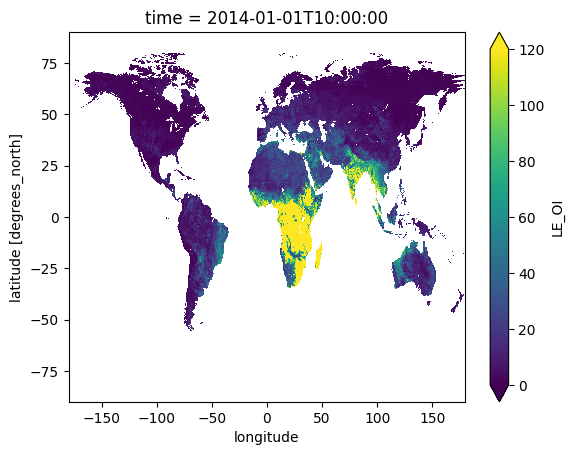

In [288]:
xr.open_zarr(LEH_PATH).LE_OI[10].plot(vmin=0,vmax=120)

In [75]:
xr.open_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/wholeEurope_fluxes_RFOI_2014_v1.3.zarr').LE_OI[:,:].sel(longitude=50,latitude=60).mean().compute(),
xr.open_zarr('/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFOI_2014_v1.3.zarr').LE_OI[:,:].sel(longitude=50,latitude=60).mean().compute(),

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


(<xarray.DataArray 'LE_OI' ()>
 array(26.19421016)
 Coordinates:
     latitude   float64 60.0
     longitude  float64 50.0,
 <xarray.DataArray 'LE_OI' ()>
 array(26.19421016)
 Coordinates:
     latitude   float64 60.0
     longitude  float64 50.0)

Release resources of the Dask cluster:

In [289]:
client.shutdown()

Verify the output is written:

In [5]:
! du -h $LEH_PATH

7.5G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/H_varmean
7.4G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/LE_varmean
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/spatial_ref
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/longitude
2.0K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/latitude
7.6G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/Gtot
4.4G	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/SIF685
2.5K	/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr/time
7.6G	/gpfs/

In [116]:
xr.open_zarr("test1127.zarr")

<xarray.Dataset>
Dimensions:       (time: 8761, latitude: 469, longitude: 690)
Coordinates:
  * latitude      (latitude) float64 81.8 81.7 81.6 81.5 ... 35.3 35.2 35.1 35.0
  * longitude     (longitude) float64 0.0 0.1 0.2 0.3 ... 68.6 68.7 68.8 68.9
  * time          (time) datetime64[ns] 2014-01-01 ... 2015-01-01
Data variables:
    Actot         (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>
    H_OI          (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>
    LE_OI         (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>
    Rn_OI         (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>
    SIF685        (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>
    SIF740        (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>
    updated_Gtot  (time, latitude, longitude) float64 dask.array<chunksize=(125, 200, 200), meta=np.ndarray>

In [81]:
LEHSS = xr.open_zarr("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFSS_2014_v1.1.zarr")

In [68]:
LEHvarmean1 = xr.open_zarr("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2.zarr")

In [67]:
LEHvarmean2 = xr.open_zarr("/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/5output_data/Europe0_fluxes_RFvarmean_2014_v1.2_5-3.zarr")

In [70]:
LEHSS.LEtot[-193,:].mean().compute(),LEHvarmean1.LE_varmean[-193,:].mean().compute(),LEHvarmean2.LE_varmean[-193,:].mean().compute()

(<xarray.DataArray 'LEtot' ()>
 array(12.1558311)
 Coordinates:
     time     datetime64[ns] 2014-12-24,
 <xarray.DataArray 'LE_varmean' ()>
 array(5.32006003)
 Coordinates:
     time     datetime64[ns] 2014-12-24,
 <xarray.DataArray 'LE_varmean' ()>
 array(5.23153288)
 Coordinates:
     time     datetime64[ns] 2014-12-24)

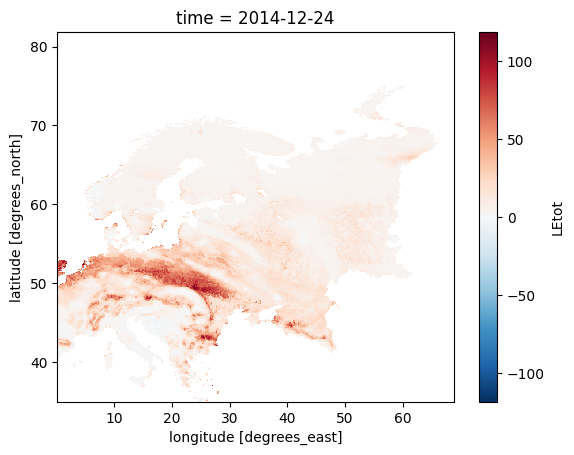

In [71]:
LEHSS.LEtot[-193,:].plot()

In [76]:
(LEHvarmean1.LE_varmean[-193,:] - LEHvarmean2.LE_varmean[-193,:] ).mean().compute()

<xarray.DataArray 'LE_varmean' ()>
array(0.08852714)
Coordinates:
    time     datetime64[ns] 2014-12-24

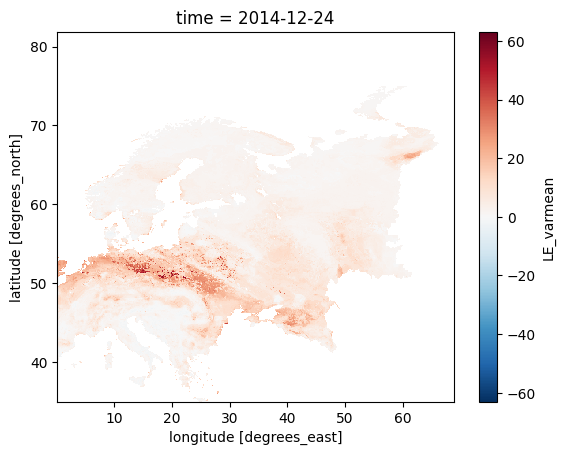

In [74]:
LEHvarmean2.LE_varmean[-193,:].plot()

In [62]:
LEH2013.nbytes/2**30

147.43593084067106

In [139]:
clip_box0 = box(0, -90,bbox[3], 90)
gdf0 = gdf.clip(clip_box0)

In [150]:
era5.sp.nbytes/2**30

10.560540854930878

In [158]:
era5.sp.rio.write_crs("EPSG:4326", inplace=True).rio.clip(gdf0.geometry.apply(mapping), gdf0.crs,drop=True).nbytes/2**30

10.529930591583252

In [156]:
era5.sp.where(era5.longitude<bbox[3]).nbytes/2**30

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


10.560540854930878